To see the videos please open this notebook in Google Colab:
<a href="https://colab.research.google.com/github/richard-warren/rl_sandbox/blob/master/dm_control_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN with `dm_control`

Here are some experiments using deep Q-Learning to solve simple continuous control tasks. I implemented [the original DQN](https://www.nature.com/articles/nature14236) and used it to solve a few tasks in the [DeepMind Control Suite](https://arxiv.org/abs/1801.00690). The key innovations from DQN are:

1. Maintain a replay buffer of experiences from which minibatches are randomly drawn during training. This decreases correlations in the training data, thereby reducing variance in the updates.
2. Keep an additional Q network for calculating targets that is an 'outdated' version of the main Q network. Every `q_update_interval` updates the weights are copied from the main to the target network. Updates are more stable because the target network is updated less frequently.

Q-Learning takes the max across actions, which is not ideal for continuous action spaces. In this implementation the action space is discretized, such that each action dimension can take a value in `linspace(action_min, actions_max, action_grid)`, where `action_grid=2` for this demo. The full action space is the cartesian product of the vectors for each dimension.

The demo is organized as follows:
1. **setup**
2. **solving tasks:** cartpole (balance+swingup), ball in cup, pendulum
3. **double DQN:** I implement [Double Q-Learning](https://arxiv.org/abs/1509.06461) and test whether it increases the accuracy of action-value estimates.

# setup


 The heart of the algorithm can be found in:
- [`train_utils.train`](https://github.com/richard-warren/rl_sandbox/blob/e5ecd61004019829997bccec8bd4ac245fe5fc6d/dm_control_tests/train_utils.py#L96), which trains an [`Agent`](https://github.com/richard-warren/rl_sandbox/blob/e5ecd61004019829997bccec8bd4ac245fe5fc6d/dm_control_tests/agents.py#L18) given an agent and a `dm_control` environment. 
- [`Agent.update`](https://github.com/richard-warren/rl_sandbox/blob/e5ecd61004019829997bccec8bd4ac245fe5fc6d/dm_control_tests/agents.py#L67), which selects minibatches and performs network updates.

To increase training speed I found it helpful to:
- *Train on the CPU rather than GPU.* The Q network is very small. [My CPU](https://cpu.userbenchmark.com/AMD-Ryzen-TR-1920X/Rating/3934) was faster than [my GPU](https://gpu.userbenchmark.com/Nvidia-RTX-2070/Rating/4029) unless batch sizes were large.
- *Perform forward passes on NumPy*. Network forward passes ended up being much faster with NumPy than TensorFlow (again, unless networks and/or batch sizes were really large).
- *Train multiple agents in parallel*. Training results could be somewhat idiosyncratic even with the same hyperparameters, so I train 12 agents in parallel to make sure results were robust.

Below are some utility functions for plotting performance and showing rollouts for trained agents.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from dm_control_tests import train_utils, plot_utils
from dm_control_tests.agents import Agent
import matplotlib.pyplot as plt
from dm_control import suite
import tensorflow as tf
import seaborn as sns
import numpy as np
import pickle
import os

tf.get_logger().setLevel('ERROR')
train_utils.disable_gpu()

# plot performance over training, averaged across agents
def plot_performance(x, data, title=None):
    ax = plt.axes(xlabel='episode', ylabel='return',
                  xlim=(x[0],x[-1]), ylim=(0,1000))
    data = np.array(data)
    if data.ndim==2:
        mean = data.mean(0)
        std = data.std(0)
        ax.plot(x, data.T, color=(0,0,0), alpha=.15)
        ax.plot(x, mean)
        ax.fill_between(x, mean+std, mean-std, alpha=.15)
    else:
        ax.plot(x, data)
    if title is not None:
        ax.set_title(title)

# show a rollout for the agent with the best performance at the end of training
def show_best_agent_rollout(agents_dir, framerate=30, epsilon=.05, rand_seed=None):
    with open(os.path.join(agents_dir, 'training_data'), 'rb') as file:
        training_data = pickle.load(file)
    best_agent = np.argmax(training_data['avg_returns'][:,-1])
    agent, metadata = train_utils.load_agent(
        os.path.join(agents_dir, 'agent{:03d}'.format(best_agent)))
    env = suite.load(*metadata['domain_and_task'])
    return plot_utils.show_rollout_ipython(
        agent, env, epsilon=epsilon, framerate=framerate, rand_seed=rand_seed)

## hyperparameters

### training
Each action dimension is discretized into `action_grid=2` actions. This makes training fast, but it also means a given action can't be set to `0`. The replay buffer has length `buffer_length=50000` and is initialized using random actions prior to training. The Q network has hidden layers of size `units_per_layer=(12,24)`.  The target Q network is updated after every `q_update_interval=100` updates of the main Q network.

The temporal resolution of `dm_control` is somewhat high. During exploration, especially with sparse rewards, the sequence of correctly chosen actions necessary to discover the reward may be quite long. I therefore repeat each action `action_repeats=2` times. Furthermore, I only perform network updates every `steps_per_update=4` iterations. The updates, rather than the physics simulations, were the speed bottleneck. Less frequent updates allow the agent to see more episodes over ~ the same compute time.

I train for `episodes=200` episodes with `batch_size=64`, acting $\epsilon$-greedy with $\epsilon$ linearly annealed from `epsilon_start=1` to `epsilon_final=.1` over `epsilon_final_episode=100` episodes.

### evaluating performance
Every `eval_interval=10` episodes I evaluate performance by averaging the return from 5 rollouts with $\epsilon = .05$. `n_agents=12` agents are trained in parallel, and I plot the average +- standard deviation of the (average) return across these agents (with individual agents plotted as thin gray lines).

In [2]:
# agent
agent_args = dict(
    action_grid = 2,            # number of discrete actions per action dimension
    units_per_layer = (12,24),  # hidden units per layer
    buffer_length = 50000,
    q_update_interval = 100,    # q updates per q_target update
    learning_rate = .001,       # learning rate (adam optimizer)       
)

# training
train_args = dict(
    episodes = 200,
    eval_interval = 10,
    batch_size = 64,
    action_repeats = 2,         # repeat each action this number of times during training
    steps_per_update = 4,       # environment steps before updating q
    gamma = .99,
    epsilon_start = 1,
    epsilon_final = .1,
    epsilon_final_episode = 100,   # episode at which epsilon_final is reached
)

# solving simple tasks

I worked on `dm_control` tasks with action space dimensionality <=2: `cartpole`, `ball_in_cup`, and `pendulum`. Reasonable policies seemed to emerge, although there was some variability across agents.

## cartpole (balance)

I use `train_utils.train_agents_parallel` to train (and save to disk) multiple agents in parallel. Cartpole (balance) was solved quite nicely:

training agent(s)...


100%|██████████| 200/200 [32:17<00:00,  9.69s/it]


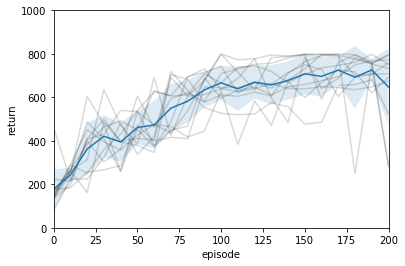

In [5]:
episode_num, avg_returns = train_utils.train_agents_parallel(
    ('cartpole', 'balance'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_balance')
plot_performance(episode_num, avg_returns)

Here's an $\epsilon=.05$ rollout for the agent with the best performance at the end of training. It doesn't look like anything is happening, which is just what we want for this task:

In [23]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_balance', epsilon=.05)

## cartpole (swingup)

Swingup (non-sparse) is a bit more challenging, but DQN works here as well:

training agent(s)...


100%|██████████| 200/200 [31:55<00:00,  9.58s/it]


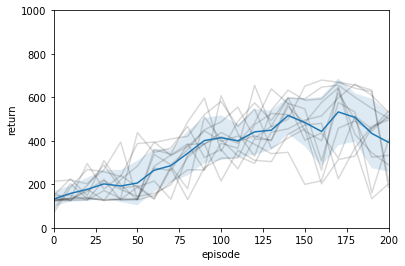

In [4]:
episode_num, avg_returns = train_utils.train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_swingup')
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_swingup', epsilon=.05)

## ball in cup

Ball in cup has two action dimensions. Performance across agents was more variable here, but performance was good overall:

training agent(s)...


100%|██████████| 200/200 [32:28<00:00,  9.74s/it]


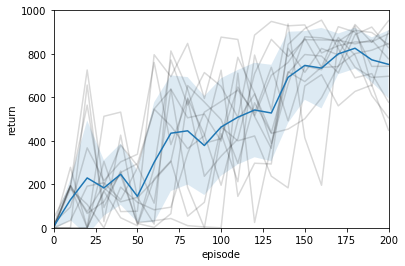

In [4]:
episode_num, avg_returns = train_utils.train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/ball_in_cup')
plot_performance(episode_num, avg_returns)

In [15]:
show_best_agent_rollout('dm_control_tests/agents/ball_in_cup', epsilon=0, rand_seed=1)

## pendulum

To show how the action-value function evolves over time I train a single agent on `pendulum`. The state space is two-dimensional (angle and velocity), and with discretization $\mathcal{A}=(-1,1)$. This means we can make nice heat maps that show action preference over the two-dimensional state space.

First let's train the agent. I found it necessary to set $\gamma=1$ (the reward is sparse here, and the agent has to swing back and forth several times to get it, so too much discounting can be problematic).

One detail: in the `pendulum` environment the angle $\theta$ is expressed with two values, $(\cos(\theta), \sin(\theta))$ (I'm guessing this is to get rid of the discontinuity in an angular representation?). I convert to $\theta$ below so I can fit things into a nice two-dimensional plot.

training agent(s)...


100%|██████████| 200/200 [20:55<00:00,  6.28s/it]


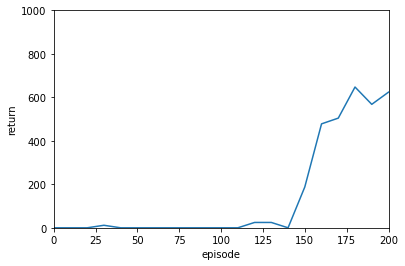

In [5]:
env = suite.load('pendulum', 'swingup')
train_utils.rand_seed_reset(env, 0)
agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
train_utils.initialize_buffer(agent, env, verbose=False)

# adjust gamma for this task
train_args_temp = train_args.copy()
train_args_temp['gamma'] = 1

# create state space grid points
bins = 40
angle_lims = (-np.pi/2, np.pi/2)
vel_lims = (-10,10)
axis_grids = [np.linspace(lims[0], lims[1], num=bins) for lims in (angle_lims, vel_lims)]
grid = np.array(np.meshgrid(*axis_grids)).reshape(2, -1).T
grid_predict = np.vstack((np.cos(grid[:,0]), np.sin(grid[:,0]), grid[:,1])).T  # first two columns are cos(x), sin(x) instead of x for predictions

# this callback function will be evaluated repeatedly during training
def compute_prediction_grid(agent, env):
    q_map = agent.q.predict(grid_predict).reshape(bins, bins, 2)
    return q_map

episode_num, returns, q_maps = train_utils.train(
    agent, env, **train_args_temp, verbose=False, callback=compute_prediction_grid)
returns = [np.mean(r) for r in returns]
plot_performance(episode_num, returns);

The plot above shows the agent has learned a useful policy after ~150 episodes.

The following video shows how preference for one action (blue) over the other (red) evolves over time. There is little preference initially (white), but a pretty structure emerges over training:

In [168]:
preference_maps = [m[:,:,0] - m[:,:,1] for m in q_maps]
abs_max = np.abs(np.array(preference_maps)).max()
plot_utils.display_video(
    preference_maps, framerate=3, is_plot=True,
    imshow_args={'extent': angle_lims+vel_lims, 'cmap': 'bwr',
                 'vmin': -abs_max, 'vmax': abs_max},
    xlabel='angle', ylabel='velocity')

The value function is both pretty and functional. See a sample rollout here:

In [166]:
plot_utils.show_rollout_jupyter(agent, env, epsilon=0, rand_seed=5)

# double q learning

The max operation in Q-Learning can lead to overly optimistic value functions. In Double-Q Learning two Q functions are learned in parallel (typically on independent samples of data). One network is used to evaluate the actions selected by the other. If the functions are $Q^a$ and $Q^b$, then the target used when updating $Q^a$ is:

$$
\text{target}^a = R_{t+1} + \gamma Q^b(S_{t+1}, \text{argmax}_{a} Q^a(S_{t+1}, a) )
$$

[Double DQN](https://arxiv.org/abs/1509.06461) doesn't train networks on independent samples. Rather, it takes advantage of there already be two Q networks, which are (usually) different from one another. The target Q network, which should be more stable, is used for evaluating the actions selected by the main Q network.

As in the original paper, I would like to check that using double DQN increases the accuracy of the action-value function. For DQN and double DQN agents I'll compute actual returns from a series of rollouts and compare these to returns estimated by their respective value-functions.

training agent(s)...


100%|██████████| 200/200 [33:41<00:00, 10.11s/it]


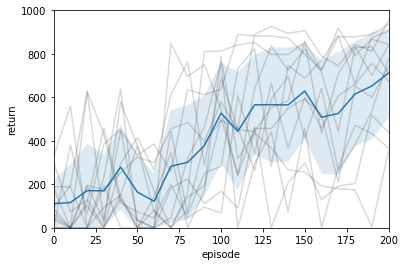

In [3]:
# train double dqn agents
agent_args_dq = agent_args.copy()
agent_args_dq['double_dqn'] = True

episode_num, avg_returns = train_utils.train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args_dq, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/ball_in_cup_dq')
plot_performance(episode_num, avg_returns)

In [14]:
# show double dqn agent rollout
show_best_agent_rollout('dm_control_tests/agents/ball_in_cup_dq', epsilon=0, rand_seed=1)

Performance was quite similar over the course of training for DQN and Double DQN, with both algorithms performing well after 200 episodes:

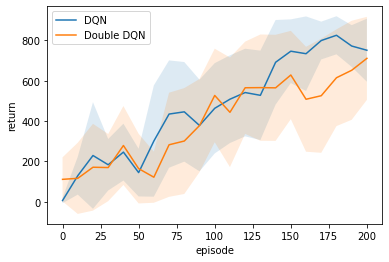

In [4]:
q_data  = 'dm_control_tests/agents/ball_in_cup/training_data'
dq_data = 'dm_control_tests/agents/ball_in_cup_dq/training_data'
ax = plt.axes(xlabel='episode', ylabel='return')

for training_data in (q_data, dq_data):
    with open(training_data, 'rb') as f:
        training_data = pickle.load(f)
    x = training_data['episode_num']
    data = np.array(training_data['avg_returns'])
    mean = data.mean(0)
    std = data.std(0)
    ax.plot(x, mean)
    ax.fill_between(x, mean+std, mean-std, alpha=.15)
ax.legend(('DQN', 'Double DQN'));

Now we'll assess evaluation accuracy for DQN and Double DQN by comparing actual returns with returns predicted by the Q function. For cartpole (balance) I'll collect returns from 10 agents with 5 rollouts each (for both DQN and Double DQN agents) and plot actual vs. predicted return densities.

One detail: episodes being truncated after 1000 steps will cause later returns to be underestimated. Therefore, when computing returns the final reward $R_T$ is given the remaining weight in the gamma distribution, e.g.

\begin{align}
G_t &= \sum_{i=t}^{T-1} \gamma^{i-t} R_i + \sum_{i=T}^\infty \gamma^{i-t} R_T \\
&= \sum_{i=t}^{T-1} \gamma^{i-t} R_i + \gamma^{T-t} \sum_{i=0}^\infty \gamma^{i} R_{T} \\ 
&= \sum_{i=t}^{T-1} \gamma^{i-t} R_i + \frac{\gamma^{T-t} R_{T}}{1-\gamma}
\end{align}

I compute returns by looping backwards across an episode using $G_t = R_t + \gamma G_{t+1}$. This means the above equation can be implemented by settings $G_T = \frac{R_T}{1-\gamma}$ and then computing recursively thereafter. I still want to avoid returns that start close to the end of an episode, so I only included returns for which $\gamma^{T-t}<.01$ (so the truncated portion of the $\gamma$ distribution is negligible).

In [5]:
# compare DQN and Double DQN evaluation accuracy
n_agents = 10
n_rollouts = 5  # per agent
gamma_thresh = .01
env = suite.load('cartpole', 'swingup')
agent_q  = 'dm_control_tests/agents/cartpole_swingup/'
agent_dq = 'dm_control_tests/agents/cartpole_swingup_dq/'


# returns will be truncated near end of episodes, so only consider early returns
# with enough samples s.t. discounting makes further samples negligible
last_ind = int(env._step_limit - np.argmax(
    np.power(train_args['gamma'], np.arange(env._step_limit)) < gamma_thresh))

q_data = {'returns': [], 'predictions': []}
dq_data = {'returns': [], 'predictions': []}

for agent_name, data in zip((agent_q, agent_dq), (q_data, dq_data)):  # for dqn, double dqn
    for agent_num in range(n_agents):
        agent = train_utils.load_agent(
            os.path.join(agent_name, 'agent{:03d}'.format(agent_num)))[0]
        
        for i in range(n_rollouts):
            # rollout
            predictions, rewards = [], []
            time_step = env.reset()
            while not time_step.last():
                action = agent.select_action(time_step, train_args['epsilon_final'])
                action_idx = agent.index_from_action(action)
                time_step = env.step(action)
                rewards.append(time_step.reward)
                x = agent.get_observation_vector(time_step)
                predictions.append(agent.predict(x, agent.q)[action_idx])

            # compute actual returns in reverse
            # (multiply final return by integral of gamma function to account for episode termination)
            returns = [rewards[-1] * (1/(1-train_args['gamma']))]
            for r in reversed(rewards[:-1]):
                returns.insert(0, r + train_args['gamma']*returns[0])  # G_t = G_t + \gamma G_{t+1}
            
            data['returns'] += returns[:last_ind]
            data['predictions'] += predictions[:last_ind]

Here are densities for actual vs. predicted return. Both DQN and Double DQN were fairly, and comparably, accurate. I suspect the benefits of Double DQN are minimal because I copy weights to the Q target network every `100` updates, which is quite frequent compared to the `10000` used in the original paper. They should therefore give similar action-value estimates.

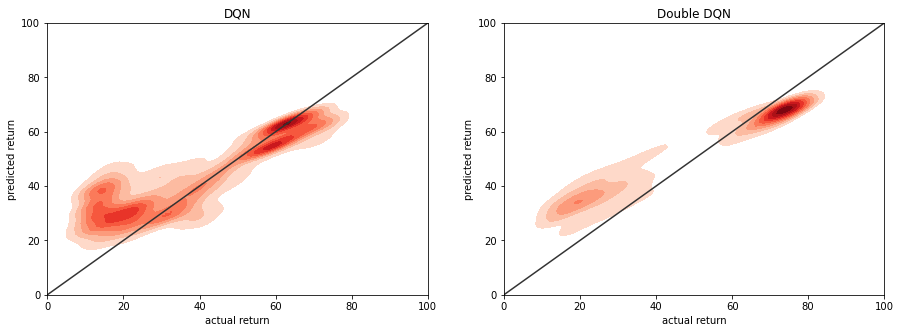

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, data, title in zip(range(2), (q_data, dq_data), ('DQN', 'Double DQN')):
    ax[i].set(xlim=(0,100), ylim=(0,100), xlabel='actual return', ylabel='predicted return', title=title)
    sns.kdeplot(data['returns'], data['predictions'], ax=ax[i], shade=True, shade_lowest=False, cmap='Reds')
    ax[i].plot([0,100], [0,100], color=(.2,.2,.2))

# optimistic initializations

I started playing around with a continuous-state-space analogue of the optimistic initialization I used in the `gridworld` demo. The goal was to make the network think all states/actions are pretty good prior to experiencing anything. To do this, in [`train_optimistic_q`](https://github.com/richard-warren/rl_sandbox/blob/b219d61f4abb24f5bfae2fb7872808af39969475/dm_control_tests/train_utils.py#L61) I initialize Q networks by training them to output `optimistic_q=10` for states uniformly sampled throughout state space. I then reset the training optimizer and proceed with training.

I performed this experiment in the `point_mass` environment, as it is closest to the 2D gridworld I previously tried. However,the optimistic initialization appeared to *slow down* learning. With `optimistic_q=10` learning didn't occur over the first 200 episodes, whereas `optimistic_q=1` had only a small amount of learning towards the end of the 200 episodes (latter not shown).

First I'll train agents and show a sample rollout using the previous hyperparameters:

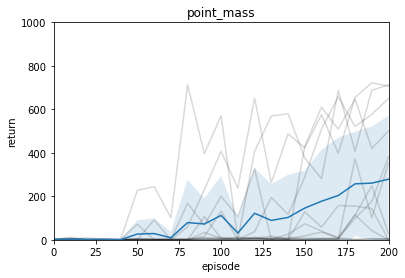

In [6]:
episode_num, avg_returns = train_utils.train_agents_parallel(
    ('point_mass', 'easy'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/point_mass')
plot_performance(episode_num, avg_returns, title='point_mass')

In [12]:
show_best_agent_rollout('dm_control_tests/agents/point_mass', rand_seed=0)

Now I'll traing agents with `optimistic_q=10` (so all state-actions have initial values of ~10 prior to interacting with the environment). Learning doesn't occur at all!

training agent(s)...


100%|██████████| 200/200 [32:24<00:00,  9.72s/it]


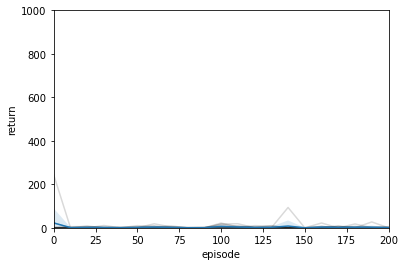

In [9]:
episode_num, avg_returns = train_utils.train_agents_parallel(
    ('point_mass', 'easy'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/point_mass_optimistic',
    optimistic_q=10)
plot_performance(episode_num, avg_returns)

Preliminary thoughts:
- When the state-action space is discrete and small, it only takes a few samples of each state-action pair to drag down the optimistic initial values. With function approximation, the speed with which this occurs should relate to the generalization ability of the network, e.g. dragging down one point in state-action space ideally drags down neighboring points (which may occur to a lesser extent with larger networks). It may take lots of interaction with the world until the entire state-action space is effectively updated. Perhaps increasing initial learning rates would help here.
- It would be nice to test this hypothesis by seeing how coverage of the state space evolves over time with and without optimistic initialization. I'm guessing optimistic initialization drives better state coverage at the expense of early rewards.
- This approach is beneficial when there is some proximal reward whose consumption may prevent discovery of some larger, distal reward. It might be fun to modify `point_mass` to add an additional, large reward far from the starting point, thus making this more analogous to the initial experiment in the `gridworld demo`.
